# Анализ товарного ассортимента интернет-магазина.

**Задание:**
- Проанализировать товарный ассортимент
- Проведите исследовательский анализ данных
- Проверьте статистические гипотезы

**Описание данных:**\
Датасет представляет собой историю транзакций интернет-магазина товаров для дома и быта "Пока все ещё тут".\
Файл ecommerce_dataset.csv содержит колонки:\
date — Дата заказа\
customer_id — Идентификатор покупателя\
order_id — Идентификатор заказа\
product — Наименование товара\
quantity — Количество товара в заказа\
price — Цена товара\
Файл с данными в приложении к задаче.

**Кто заказчик и в каком формате оформить результаты?**
Это запрос менеджера проекта, который отвечает за актуальность товарного ассортимента. Ему нужна небольшая презентация, как итог работы. 

**Цель исследования: какую проблему планируется решить, на какие вопросы нужно дать ответ в исследовании?**\
Условно две подзадачи:
1. Сгруппировать товары по группам (т.е. по тематикам).
2. Разбить товары на основной и дополнительный ассортименты.

Условно основные - это те товары, которые чаще встречаются у определенных сегментов пользователей, например, пользователи, которые регулярно покупают детские товары.\
Дополнительный ассортимент - это те товары, которые часто берут в довесок. Такие товары могут встречаться у разных сегментов пользователей, например, те кто берет детские товары также часто как и те кто берет кухонные товары покупают в довесок бытовую химию.
На основе этого интересуют любые insights относительно того, какие товары чаще дополнительные, какие тематики товаров чаще основные. Их объемы продаж за период. В общем все, что может помочь планировать закупки.

**Проверка гипотез:**\
- гипотеза различия стоимости товаров в различных тематических группах.
- гипотезы по результатам EDA

<a id="content"></a>
## Содержание
[Шаг 1. Загрузка данных и общая оценка датасета](#1)

[Шаг 2. Подготовка данных](#2)
- [2.1. Обработка столбца 'date'](#21)
- [2.2. Обработка дубликатов](#22)
- [2.3. Проверка корректности данных](#23)
- [2.4. Создание дополнительных полей](#24)

[Шаг 3. Создание категорий товаров (лемматизация)](#3) 
- [3.1. Отработка подходов к лемматизации](#31)
- [3.2. Составление словаря и лемматизация товарных групп](#32)
- [3.3. Проверка результатов](#33)

[Шаг 4. Разделение на основной и дополнительный ассортимент](#4)

[Шаг 5. Общий анализ (EDA)](#5)

[Шаг 6. Проверка гипотез](#6)
- [6.1 Проверка гипотезы: "Равенство средней цены товаров основного и доп. ассортимента"](#61)
- [6.2 Проверка гипотезы: "Сезонный рост объема продаж  в товарной группе: 'цветы живые'"](#62)
- [6.3 Проверка гипотезы: "Падение продаж в течение года"](#63)

**[Общий вывод](#summary)**

## Загрузка библиотек и настройка окружения

In [1]:
!pip install pymystem3 

In [2]:
# загрузка библиотек
import pandas as pd
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# импорт библиотек для лемматизации:
from pymystem3 import Mystem
m = Mystem()
from collections import Counter

In [4]:
# библиотеки построения ML моделей
# import sklearn
# from sklearn.model_selection import train_test_split
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.linear_model import LogisticRegression

# импорт из библиотеки sklearn метрик
# from sklearn.metrics import f1_score
# from sklearn.metrics import accuracy_score
# from sklearn.metrics import precision_score
# from sklearn.metrics import recall_score
# библиотеки для кластеризации

In [5]:
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans

In [6]:
# настройка окружения
pd.options.display.max_columns=None
pd.options.display.float_format='{:.2f}'.format
sns.set(style='whitegrid')
plt.style.use('seaborn-pastel')

# конвертер для корректного отражения datetime данных на графиках
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

<a id="1"></a>
## 1. Загрузка данных и общая оценка датасета [▲](#content)

In [7]:
# загрузка датасета
df_sales = pd.read_csv('ecommerce_dataset.csv')

In [8]:
# визуальная оценка
df_sales.head()

,date,customer_id,order_id,product,quantity,price
0,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Алое Вера, d12, h30",1,142.00
1,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Кофе Арабика, d12,...",1,194.00
2,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Радермахера d-12 см h-20 см,1,112.00
3,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Хризолидокарпус Лутесценс d-9 см,1,179.00
4,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Циперус Зумула d-12 см h-25 см,1,112.00


In [9]:
# типы данных по полям
df_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6737 entries, 0 to 6736
Data columns (total 6 columns):
date           6737 non-null int64
customer_id    6737 non-null object
order_id       6737 non-null int64
product        6737 non-null object
quantity       6737 non-null int64
price          6737 non-null float64
dtypes: float64(1), int64(3), object(2)
memory usage: 315.9+ KB


**Вывод:**
- столбец 'date' требует пребразования данных в формат datetime

<a id="2"></a>
## 2. Подготовка данных [▲](#content)

<a id="21"></a>
#### 2.1. Обработка столбца 'date'  [**↑**](#2)

In [10]:
# Похоже дата дана в формате год-месяц-день-час
# Выполняем необходимые преобразования, часы отбрасываем (берем только первые 8 знаков строки)
df_sales['date'] = pd.to_datetime(df_sales['date'].astype('str').str[:8], yearfirst=True)

In [11]:
# проверяем доступный диапазон дат после обработки
df_sales['date'].describe()

count                    6737
unique                    394
top       2019-05-13 00:00:00
freq                      146
first     2018-10-01 00:00:00
last      2019-10-31 00:00:00
Name: date, dtype: object

**Имеем данные за 13 месяцев: с 01.10.2018 по 31.10.2019**

<a id="22"></a>
#### 2.2. Обработка дубликатов [**↑**](#2)

In [12]:
# проверка на дубликаты
print('Число полных дубликатов в таблице:', df_sales.duplicated().sum())

Число полных дубликатов в таблице: 966


In [13]:
# визуальная проверка дубликатов
df_sales[df_sales.duplicated(keep=False)==True].sort_values(by='product').head(4)

,date,customer_id,order_id,product,quantity,price
1999,2019-02-25,075873aa-644c-4a09-9253-204f3156ac7b,70438,"Ёрш унитазный с деревянной ручкой , Ваир 1712012",20,56.00
2021,2019-02-25,075873aa-644c-4a09-9253-204f3156ac7b,70438,"Ёрш унитазный с деревянной ручкой , Ваир 1712012",20,56.00
4818,2019-06-07,4723417a-8c73-4502-9600-75187124fb5c,71638,Антинакипин для утюгов Ампулы 10 мл по 5 шт UN...,1,164.00
4817,2019-06-07,4723417a-8c73-4502-9600-75187124fb5c,71638,Антинакипин для утюгов Ампулы 10 мл по 5 шт UN...,1,164.00


**Некоторые записи полностью дублируются - их удаляем:**

In [14]:
# удаление дубликатов 
df_sales.drop_duplicates(inplace=True)
df_sales.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5771 entries, 0 to 6736
Data columns (total 6 columns):
date           5771 non-null datetime64[ns]
customer_id    5771 non-null object
order_id       5771 non-null int64
product        5771 non-null object
quantity       5771 non-null int64
price          5771 non-null float64
dtypes: datetime64[ns](1), float64(1), int64(2), object(2)
memory usage: 315.6+ KB


**После удаления дубликатов остается 5771 записей**

<a id="23"></a>
#### 2.3. Проверка корректности данных [**↑**](#2)

In [15]:
# оцениваем интервалы значений для цифровых столбцов
df_sales[['quantity', 'price']].describe()

,quantity,price
count,5771.00,5771.00
mean,2.69,497.61
std,16.45,912.19
min,1.00,9.00
25%,1.00,90.00
50%,1.00,149.00
75%,1.00,487.00
max,1000.00,14917.00


Столбцы 'quantity', 'price' имеют большой разброс данных, максимум более чем на порядок отличается от среднего. Выполняем проверку максимальных значений.

In [16]:
# оценка  данных в столбце 'quantity'
df_sales.sort_values(by='quantity', ascending=False).head()

,date,customer_id,order_id,product,quantity,price
5456,2019-06-18,312e9a3e-5fca-43ff-a6a1-892d2b2d5ba6,71743,"Вантуз с деревянной ручкой d14 см красный, Bur...",1000,675.00
5071,2019-06-11,146cd9bf-a95c-4afb-915b-5f6684b17444,71668,Вешалки мягкие для деликатных вещей 3 шт шоколад,334,148.00
3961,2019-05-20,5d189e88-d4d6-4eac-ab43-fa65a3c4d106,71478,Муляж ЯБЛОКО 9 см красное,300,51.00
1158,2018-12-10,a984c5b7-ff7e-4647-b84e-ef0b85a2762d,69289,"Ручка-скоба РС-100 белая *Трибатрон*, 1108035",200,29.00
568,2018-11-01,aa42dc38-780f-4b50-9a65-83b6fa64e766,68815,Муляж ЯБЛОКО 9 см красное,170,51.00


**Экстремальные значения 'quantity' не похожи на ошибку, возможно это оптовая покупка.**

In [17]:
# оценка  данных в столбце 'quantity'
df_sales.sort_values(by='price', ascending=False).head()

,date,customer_id,order_id,product,quantity,price
5992,2019-07-29,0d87f4ae-465a-4fac-81e6-5d629761783e,72139,Сушилка уличная Leifheit 85210 LINOMATIC V 400...,1,14917.00
2697,2019-04-05,c0c60544-3a99-49d0-8a8e-cf7f293c22cb,71035,Сумка-тележка хозяйственная Andersen Royal Sho...,1,8737.00
1981,2019-02-24,ac250053-a236-467a-97d2-ddbb9bf4a1ba,70423,Сумка-тележка хозяйственная Andersen Alu Star ...,1,8437.00
2997,2019-04-21,19d904d8-8d16-476d-8f66-b2a3b7a23660,71227,Сумка-тележка хозяйственная Rolser MNB019 rojo...,1,8077.00
6629,2019-10-16,d5584388-ffbe-42fd-a746-a98828ec919f,72992,Стремянка 7 ступенчатая Hailo 8040-707 XXL 13 ...,1,7724.00


**В столбце 'product' максимальные цены вполне соответствуют названиям товаров.**

<a id="24"></a>
#### 2.4. Создание дополнительных полей [**↑**](#2)

In [18]:
# Добавляем столбец 'summ' с суммой продажи:
df_sales['summ'] = df_sales['price'] * df_sales['quantity']

In [19]:
# столбец с месяцем продажи (для группировок)
df_sales['month'] = df_sales['date'].astype('datetime64[M]').dt.date

<a id='3'></a>
## 3. Создание категорий товаров (лемматизация)  [▲](#content)

<a id="31"></a>
#### 3.1. Отработка подходов к лемматизации [**↑**](#3)

In [20]:
print('Общее число товарных позиций, шт.:', df_sales['product'].value_counts().count())
print('Топ-10 наиболее часто покупаемых товаров, кол-во заказов:')
df_sales['product'].value_counts().head(10)

Общее число товарных позиций, шт.: 2343
Топ-10 наиболее часто покупаемых товаров, кол-во заказов:


Пеларгония розебудная Red Pandora укорененный черенок         72
Сумка-тележка 2-х колесная Gimi Argo красная                  67
Пеларгония розебудная Prins Nikolai укорененный черенок       63
Пеларгония зональная диам. 12 см сиреневый полумахровый       56
Сумка-тележка 2-х колесная Gimi Argo синяя                    55
Пеларгония розебудная Mary укорененный черенок                40
Пеларгония розебудная Margaretha укорененный черенок          32
Пеларгония розебудная Queen Ingrid укорененный черенок        31
Рассада Кабачка сорт Зебра кассета 6 шт E6                    28
Пеларгония зональная диам. 12 см темнорозовая полумахровая    27
Name: product, dtype: int64

У нас большое число товарных позиций - **2343**, кроме разбивки по названию пытаемся найти еще какой нибудь критерий для выделения товарных групп, например цена-продажи. Дополнительно это даст оценку продаж отдельных товаров в общей структуре.

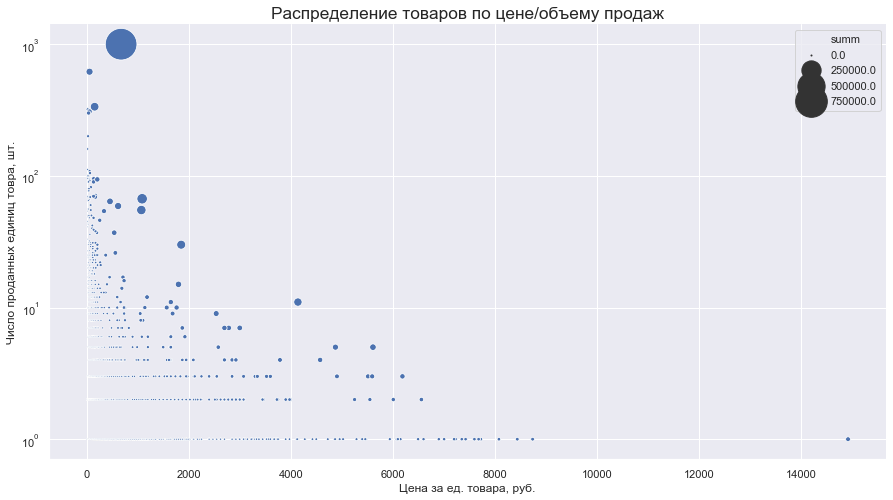

In [21]:
df_sales_summary = df_sales.groupby('product').agg({'price':'mean', 'quantity':'sum', 'summ':'sum'}).reset_index()
# построение графика 
sns.set('notebook')
f, ax = plt.subplots(figsize=(15, 8))
sns.scatterplot(data=df_sales_summary, x='price', y='quantity', size='summ',  sizes=(1, 1000), ax=ax);
# Добавляем заголовок легенду и подписи осей
ax.set_title('Распределение товаров по цене/объему продаж', fontdict={'fontsize': 'x-large'})
ax.set(ylabel="Число проданных единиц товра, шт.", yscale='log')
ax.set(xlabel="Цена за ед. товара, руб.")
sns.despine(ax=ax);

In [22]:
# Выводим ТОП-5 по стоимости продаж
df_sales_summary.sort_values(by='summ', ascending=False).head()

,product,price,quantity,summ
119,"Вантуз с деревянной ручкой d14 см красный, Bur...",675.00,1000,675000.00
1618,Сумка-тележка 2-х колесная Gimi Argo красная,1087.00,67,72829.00
1619,Сумка-тележка 2-х колесная Gimi Argo синяя,1071.11,55,58911.00
1195,Простынь вафельная 200х180 см WELLNESS RW180-0...,1852.00,30,53232.00
192,Вешалки мягкие для деликатных вещей 3 шт шоколад,156.00,335,49596.00


Очевидно имело место крупная разовая сделка по покупке вантузов, в последующем проведем очистку данных от подобных выбросов.
Дополнительно создаем функцию для вывода только лемм существительных, чтобы не отвлекаться на прилагательные наподобие "красный", "пушистый" и т.п., которые не совсем подходят для характеристики товарных групп. Однако стандартная функция lemmatize также периодически применялась.

In [23]:
# analyze_noun(string)
# Функция использует analyze из pymystem3 (необходима установка pymystem3)
# из полученного массива выбираются только леммы существительных (имеют код S в выходном массиве)
# 'gr' - ключ в выходном словаре содержащий информацию о форме слова
# 'lex' - ключ в выходном словаре содержащий базовую лемму слова 
# Пример:
# string = 'Пеларгония розебудная Red Pandora укорененный черенок'
# out: пеларгония, черенок
def analyze_noun(string):
    result = []
    for val in m.analyze(string):
        if val.get('analysis') != [] and val.get('analysis') != None:
            if val.get('analysis')[0].get('gr')[0] == 'S':
                result.append(val.get('analysis')[0].get('lex'))
    return result        

Предварительно оцениваем частоту основных лемм

In [24]:
# подготавливаем список товаров для лемматизации
# предварительно все символы переводятся в нижний регистр
products = df_sales['product'].str.lower().value_counts().reset_index() 
products.set_axis(['product', 'count'], axis = 'columns', inplace=True)
# формирум список всех слов в названиях
lemma_summ = ' '.join(products['product'])
# получаем датафрейм со всеми леммами и их частотой
df_sales_lemma = pd.Series(data=Counter(analyze_noun(lemma_summ))).reset_index()
# для удобства переименовываем столбцы 
df_sales_lemma.columns = ['lemma', 'count']

In [25]:
# в полученной таблице много одиночных символов, цифр, которые вряд ли могут быть названием для товарной группы
# ограничим полученный список словами состоящими более чем из 3 символов
df_sales_lemma = df_sales_lemma.loc[df_sales_lemma['lemma'].str.len() >3]
print('Число лемм встречающихся в названиях товаров более 10 раз:', 
              df_sales_lemma.loc[df_sales_lemma['count']>10].shape[0])

display(df_sales_lemma.sort_values(by='count', ascending=False).head(10))

Число лемм встречающихся в названиях товаров более 10 раз: 99


,lemma,count
7,рассада,221
9,сорт,171
11,кассета,170
31,белье,144
59,доска,132
37,горшок,130
30,сушилка,120
17,цветок,118
51,объем,114
3,тележка,108


<a id="32"></a>
#### 3.2. Составление словаря и лемматизация товарных групп [**↑**](#3)

Лемматизация проводилась итерациями. После добавления очередного элемента словаря оценивались лидирующие по частоте леммы и словарь снова дополнялся. Целью было достичь размера группы "прочие товары" на 5 месте по емкости товарных позиций.

In [26]:
df_sales = df_sales 
df_sales['group'] = 'прочие товары'
# Cловарь для посиска соответствия лемм в 'product' названию товарной группы в 'group'.
# !!! ВАЖНО: замена производится по порядку записей в словаре. УЧИТЫВАТЬ ПРИ СОСТАВЛЕНИИ !!!
# структура словаря: 
# регулярное выражение для поска строки в 'product': название товарной группы
###################################################################################
group_dict = {
    'рассад.*.цвет':'рассада цветов',
    '^[Рр]ассад':'рассада',
    '[Сс]редство.*мл':'бытовая химия',
    '\s46500\d{8}':'семена',
    '\s46600\d{8}':'семена',
    '[Ll]uminar':'посуда',
    '[Гг]лад.*[Дд]оск':'гладильные доски и аксессуары',
    '[Сс]ушилк.*[Бб]ел':'сушилки для белья',
    '[Тт]ележк':'тележки и аксессуары',
    '[Гг]ерань.*пеларгон':'цветы живые',
    '[Кк]ашпо':'уют',
    '[Пп]еларгон':'цветы живые',
    '[Мм]уляж':'цветы искусственные и муляжи',
    '[Ии]скусственн.*цвет':'цветы искусственные и муляжи',
    '[Ии]скуственн.*цвет':'цветы искусственные и муляжи',
    '[Цц]вет.*искусствен':'цветы искусственные и муляжи',
    '[Тт]омат.*сорт':'семена',
    '.d-':'цветы живые',
    '[Вв]ешал':'вешалки',
    '[Шш]тор':'уют',
    '[Кк]овр':'уют',
    '[Гг]орш':'цветы живые',
    '[Кк]ассет':'рассада',
    '[Сс]тремянк':'стремянки',
    '[Тт]арелк':'посуда',
    '[Сс]катерт':'текстиль',
    '[Хх]лоп':'текстиль',
    '[Чч]ехол':'текстиль',
    '[Кк]орзин':'хозтовары',
    '[Пп]етун':'семена',
    '[Оо]бъем':'семена',
    '[Рр]учк':'хозтовары',
    '[Пп]ластмассов':'хозтовары',
    '[Лл]ожк':'посуда',
    '[Сс]ковород':'посуда',
    '[Вв]илк':'посуда',
    '[Нн]ож':'посуда',
    '[Чч]айн':'посуда',
    '[Сс]алатник':'посуда',
    '[Фф]ужер':'посуда',
    '[Сс]толов.*прибор':'посуда',
    '[Сс]такан':'посуда',
    'Leifheit':'хозтовары',
    '[Бб]анк':'посуда',
    '[Кк]онтейнер':'хозтовары',
    '[Кк]омнатн.*D':'цветы живые',
    'Rozenbal':'хозтовары',
    'Hausmann':'хозтовары',
    '[Вв]анн':'хозтовары',
    'Attribute':'хозтовары',
    '[Ww]ellness':'текстиль',
    '[Сс]алфетк':'хозтовары',
    '[Вв]едр':'хозтовары',
    '[Пп]олк':'хозтовары',
    '[Пп]осуд':'посуда',
    'Ковер':'хозтовары',
    'паста':'бытовая химия',
    '[Пп]лантац':'цветы живые',
    '[Кк]рюч':'хозтовары',
    '[Пп]одставк':'хозтовары',
    '[Нн]асадк':'хозтовары',
    '[Мм]ыл':'бытовая химия',
    '[Тт]ермос':'посуда',
    '[Вв]ыпечк':'посуда',
    
}
##################################################################################

# цикл для обработки 'product' и присваивания названий товарных групп
for reg_string, group_name in group_dict.items():
    df_sales.loc[(df_sales['group']=='прочие товары') 
                &(df_sales['product'].str.contains(reg_string)), 'group'] = group_name

# проверка результата по полученным товарным группам
display(df_sales.groupby('group')['product'].nunique().reset_index().sort_values(by='product', ascending=False))

# выполняем лемматизацию оставшихся полей без товарной группы
# делаем срез товаров без групп
products = df_sales.loc[df_sales['group'] == 'прочие товары', 'product'].str.lower().value_counts().reset_index() 
products.set_axis(['product', 'count'], axis = 'columns', inplace=True)
# формирум список всех слов в названиях
lemma_summ = ' '.join(products['product'])
# получаем датафрейм со всеми леммами и их частотой
df_sales_lemma = pd.Series(data=Counter(analyze_noun(lemma_summ))).reset_index()
# для удобства переименовываем столбцы 
df_sales_lemma.columns = ['lemma', 'count']
# в полученной таблице много одиночных символов, цифр, сокращений от названий единиц измерения, 
# которые вряд ли могут быть названием для товарной группы
# ограничим полученный список словами состоящими более чем из 3 символов
df_sales_lemma = df_sales_lemma.loc[df_sales_lemma['lemma'].str.len() >3]
df_sales_lemma.sort_values(by='count', ascending=False).head(7)

,group,product
14,цветы живые,390
13,хозтовары,271
5,рассада,231
7,семена,212
4,прочие товары,209
3,посуда,191
12,уют,148
15,цветы искусственные и муляжи,129
9,сушилки для белья,116
2,гладильные доски и аксессуары,112


,lemma,count
27,сталь,10
6,диам,7
166,россия,7
114,штука,6
115,упаковка,6
170,крышка,6
53,петля,5


In [27]:
# проверка еще не отсортированных "перспективных" лемм для группировки
# (df_sales.loc[df_sales['group']=='прочие товары']
#     .loc[df_sales['product'].str.contains('[Вв]ыпечк')].groupby('product').agg({'order_id':'count', 'price':'mean'})
# .sort_values(by='price').head(30))

In [28]:
# проверка группировки
# df_sales.loc[df_sales['group']=='семена'].head(30)

In [29]:
## проверка леммы 
df_sales.loc[df_sales['product'].str.contains('[Вв]ант')]#.groupby('product').agg({'order_id':'count', 'price':'mean'})

,date,customer_id,order_id,product,quantity,price,summ,month,group
1310,2018-12-22,709df21c-c9f3-4622-b830-4201cff05d1e,69516,Вантуз черный с пластиковой ручкой малый Д-100...,1,52.00,52.00,2018-12-01,хозтовары
1916,2019-02-20,4a7fe822-c617-460a-a477-33be987babbf,70362,"Вантуз черный с длинной ручкой (D-110 мм, L-38...",1,149.00,149.00,2019-02-01,хозтовары
5456,2019-06-18,312e9a3e-5fca-43ff-a6a1-892d2b2d5ba6,71743,"Вантуз с деревянной ручкой d14 см красный, Bur...",1000,675.00,675000.00,2019-06-01,хозтовары


<a id="33"></a>
####  3.3. Проверка результатов [**↑**](#3)

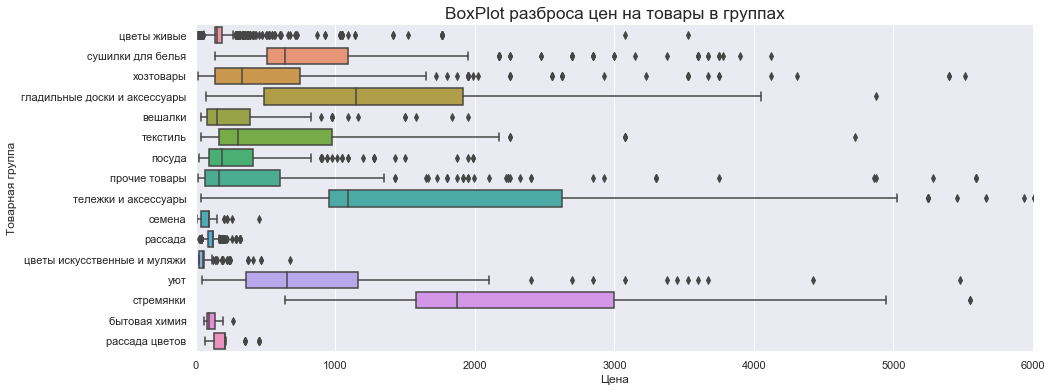

In [30]:
# Проверяем разброс числа событий на одного пользователя
f, ax = plt.subplots(figsize=(15, 6))
sns.boxplot(data=df_sales, x='price', y='group',  orient='h');
ax.set_title ('BoxPlot разброса цен на товары в группах', fontdict={'fontsize': 'x-large'})
ax.set_ylabel('Товарная группа')
ax.set_xlabel('Цена')
plt.xlim(0,6000);
plt.rc('ytick', labelsize='medium');
sns.despine(ax=ax, bottom=True);


**Вывод:** наиболее удачно, с точки зрения цены, выделены группы цветы живые, семена, рассада, цветы искуственные, бытовая химия, рассада цветов - они имеюют наименьший разброс цен. Наибольший диапазон цен в группах гладильные доски, тележки, стремянки, эти группы включают также аксессуары к этим товарам. Однако только этот параметр использовать некорректно, поскольку группа просто может включать и дорогие и дешевые товары, они могут относиться к разным целевым группам клиентов, но эта задача сейчас не стоит.

<a id='4'></a>
## 4. Разделение на основной и дополнительный ассортимент  [▲](#content)

Предполагаем, что те товары, которые покупаются клиентами постоянно и являются основным ассортиментом. Считаем какие товары покупались клиентами повторно, т.е. более одного раза: 

In [33]:
# подсчет общего числа покупок в товарной группе
df_assort_product_1 = (df_sales.pivot_table(columns='customer_id', index='product', values='order_id', aggfunc='nunique')
                .sum(axis=1).reset_index())
df_assort_product_1.columns=['product', 'summ_sales_count']

# подсчет числа повторных покупок в товарной группе
# т.е. пользователь делал покупку товара из этой группы минимум 2 раза
df_assort_product_2 = ((df_sales
                .pivot_table(columns='customer_id', index='product', values='order_id', aggfunc='nunique')
               >=2).sum(axis=1).reset_index())
df_assort_product_2.columns=['product', 'summ_sales_repeated']

# слияние таблиц
df_assort_product = df_assort_product_1.merge(df_assort_product_2, on='product', how='left')

print('Общее число товарных позиций:', df_assort_product.shape[0])
print('Число товарных позиций купленных повторно:',
      (df_assort_product['summ_sales_repeated']>=1).sum())
df_assort_product.sort_values(by='summ_sales_repeated', ascending=False).head(10)

Общее число товарных позиций: 2343
Число товарных позиций купленных повторно: 90


,product,summ_sales_count,summ_sales_repeated
1017,Пеларгония зональная диам. 12 см сиреневый пол...,52.00,5
1039,Пеларгония розебудная Mary укорененный черенок,39.00,4
1040,Пеларгония розебудная Prins Nikolai укорененны...,57.00,3
1619,Сумка-тележка 2-х колесная Gimi Argo синяя,47.00,3
1042,Пеларгония розебудная Red Pandora укорененный ...,66.00,3
1099,Петуния махровая рассада однолетних цветов в к...,17.00,2
283,Гладильная доска НИКА LORA FASHION HLF 123х46 см,6.00,2
2029,Цветок искусственный Крокус 20 см,7.00,2
1045,Пеларгония тюльпановидная EMMA,14.00,2
1041,Пеларгония розебудная Queen Ingrid укорененный...,30.00,2


Клиентами куплены повторно только 90 наименований товаров из 2343. Это не позволяет произвести разбивку ассортимента в разрезе конкретных товаров. Возможно многие товары завозились однократно, возможно есть ошибки при внесении в систему названий: отличие на 1 символ в названии или индексе создает отдельную товарную позицию. Таким образом выполняем разбивку ассортимента на основной и дополнительный по товарным группам.

В основу разделения закладываем: наличие повторных покупок клиентами, и значимость этой группы для самого магазина: общий объем продаж этой группы (по количеству) и общая стоимость продаж (как функция от цены и количества). 

In [34]:
# подсчет общего числа покупок в товарной группе
df_assort_group_1 = (df_sales.pivot_table(columns='customer_id', index='group', values='order_id', aggfunc='nunique')
                .sum(axis=1).reset_index())
df_assort_group_1.columns=['group', 'summ_sales_count']

# подсчет числа повторных покупок в товарной группе
# т.е. пользователь делал покупку товара из этой группы минимум 2 раза
df_assort_group_2 = ((df_sales
                .pivot_table(columns='customer_id', index='group', values='order_id', aggfunc='nunique')
               >=2).sum(axis=1).reset_index())
df_assort_group_2.columns=['group', 'summ_sales_repeated']

# подсчет среднего и медианы по группам
df_sales_group_stat = df_sales.groupby(['group'])['summ'].agg({'summ':['mean', 'median', 'sum']}).reset_index()
df_sales_group_stat.columns = ['group', 'group_mean', 'group_median', 'group_sum']

# слияние таблиц
df_assort_group = df_assort_group_1.merge(df_assort_group_2, on='group', how='left')
df_assort_group = df_assort_group.merge(df_sales_group_stat, on='group', how='left')
#(df_assort_group.sort_values(by='summ_sales_repeated', ascending=False)
#    .style.background_gradient(cmap=sns.light_palette('limegreen', as_cmap=True), axis=0))

C:\Users\Andrey\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version. Use                 named aggregation instead.

    >>> grouper.agg(name_1=func_1, name_2=func_2)

  


Разделение на кластеры выполним при помощи метода KMeans. Число кластеров известно из задания: 2 (основной и дополнительный ассортимент).

In [35]:
# стандартизация данных перед работой алгоритмов кластеризации
sc = StandardScaler()
# в качестве входных параметров для выделения кластеров выбираем
# group, summ_sales_count, summ_sales_repeated, group_mean, group_median, group_sum, clusters
x_sc = sc.fit_transform(df_assort_group[['summ_sales_count', 'summ_sales_repeated', 'group_sum']])
linked = linkage(x_sc, method = 'ward')

km = KMeans(n_clusters = 2, random_state=2718) # задаём число кластеров
labels = km.fit_predict(x_sc) # применяем алгоритм к данным и формируем вектор кластеров
# сохраняем метки кластера в поле нашего датасета
df_assort_group['clusters'] = labels
# выводим статистику по средним значениям наших признаков по кластеру
#df_result[str(n_clusters)] = (df_churn.groupby(str(n_clusters))['churn'].mean().reset_index()['churn'])    

# в итоговый датафрейм добавляем расчетную строку с максимальной дельтой
# между минимальным и максимальным оттоком в выделенных кластерах
(df_assort_group.sort_values(by='summ_sales_repeated', ascending=False)
    .style.background_gradient(cmap=sns.light_palette('limegreen', as_cmap=True), axis=0))

,group,summ_sales_count,summ_sales_repeated,group_mean,group_median,group_sum,clusters
14,цветы живые,615,46,267.563,150,364688,0
15,цветы искусственные и муляжи,198,15,409.164,118,124795,1
11,тележки и аксессуары,343,14,1934.59,1087,833809,0
13,хозтовары,357,13,2671.48,524,1.16209e+06,0
3,посуда,182,11,755.922,471.5,184445,1
5,рассада,122,10,137.365,120,122255,1
9,сушилки для белья,273,10,1057.22,689,318224,1
4,прочие товары,252,8,822.254,233.5,284500,1
12,уют,186,8,1158.72,974,278094,1
2,гладильные доски и аксессуары,187,7,1523.45,1386.5,322972,1


Выделяем в основной ассортимент три группы товаров: **'цветы живые', 'тележки и аксессуары', 'хозтовары'**

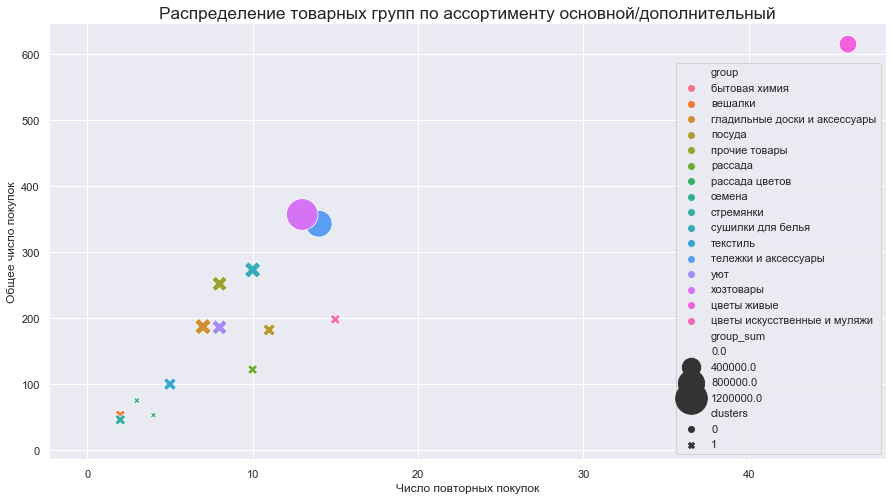

In [36]:
# делаем визуализацию с полученными кластерами ассортимента
sns.set('notebook')
f, ax = plt.subplots(figsize=(15, 8))
sns.scatterplot(data=df_assort_group, x='summ_sales_repeated', y='summ_sales_count', size='group_sum',
                hue='group', style='clusters', sizes=(0, 1000), ax=ax, legend='brief');
# Добавляем заголовок легенду и подписи осей
ax.set_title('Распределение товарных групп по ассортименту основной/дополнительный',
             fontdict={'fontsize': 'x-large'})
ax.set(ylabel="Общее число покупок")
ax.set(xlabel="Число повторных покупок")
sns.despine(ax=ax);

In [37]:
# добавляем и заполняем столбец 'assort_gr' 
df_sales['assort_gr'] = 'additional'
df_sales.loc[df_sales['group'].isin(['цветы живые', 'тележки и аксессуары', 'хозтовары']), 'assort_gr']='main'
#df_sales.loc[df_sales['group'].isin(['цветы живые', 'тележки и аксессуары', 'хозтовары'])]

**Вывод:** разбивка на группы ассортимента выполнена. К основному ассортименту отнесены группы 'цветы живые', 'тележки и аксессуары', 'хозтовары'. Можно начинать EDA.

<a id='5'></a>
## 5. Общий анализ (EDA) [▲](#content)

**Расчет перцентилей числа основных событий по пользователям**

Как было показано в предыдущих разделах, в рассматриваемом периоде есть крупные разовые сделки (например 1000 ед. вантузов на 675000 руб.) -  эти данные исказят результаты анализа сезонности продаж, поэтому проведем очистку данных от наиболее крупных покупок. При этом устанавливаем границу выше цены самого дорогого товара.

In [38]:
# Расчет 95-го и 99-го перцентилей по категории сумма покупки для основной выборки
print('Стоимость самого дорогого товара в номенклатуре:', df_sales['price'].max())
print('Расчет перцентилей для столбца summ, 99.0%, 99.9%:', np.percentile(df_sales['summ'],  [99, 99.9]))

Стоимость самого дорогого товара в номенклатуре: 14917.0
Расчет перцентилей для столбца summ, 99.0%, 99.9%: [ 5948.3  18337.82]


**Отсекаем данные по соответствующим пользователям:**

In [39]:
# очищаем датасет от покупок на сумму больше 20 000 (уровень 99,9 перцентиля):
df_sales_new = df_sales[(df_sales['summ'] < 20000)]
print('Размер датасета до очистки от выбросов:', df_sales.shape[0])
print('Размер датасета после очистки:', df_sales_new.shape[0])
print('Число записей датасета после удаления экстермумов (% от исходного):',
      np.round(df_sales_new.shape[0] / df_sales.shape[0] * 100, 2))

Размер датасета до очистки от выбросов: 5771
Размер датасета после очистки: 5765
Число записей датасета после удаления экстермумов (% от исходного): 99.9


**Вывод:** Удалены экстремумы на уровне перцентиля 99.9% по сумме продажи. Итоговый размер датасета уменьшился на 6 записей, оставляем датасет в новой редакции.

**Определение сезонности продаж**

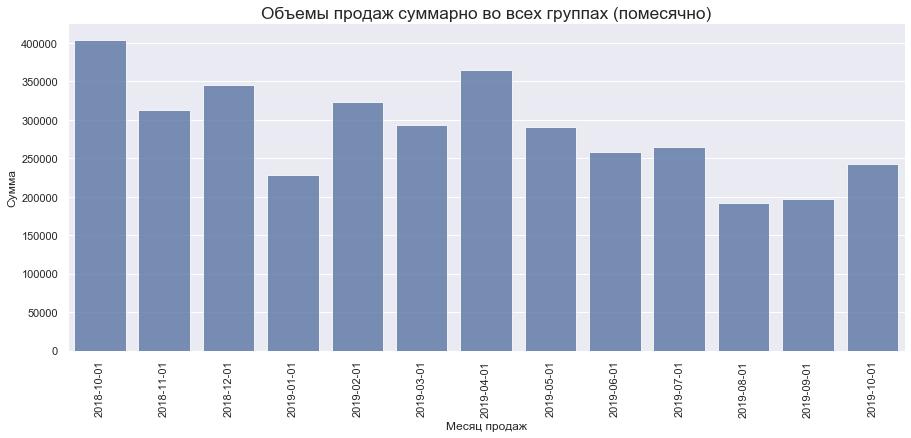

In [40]:
f, ax = plt.subplots(figsize=(15, 6))
sns.barplot(data=df_sales_new.groupby(['month'])['summ'].sum().reset_index(), y='summ', x='month',
           color='b', alpha=0.8);
ax.set_title ('Объемы продаж суммарно во всех группах (помесячно)', fontdict={'fontsize': 'x-large'})
ax.set_ylabel('Сумма')
ax.set_xlabel('Месяц продаж')
#plt.xlim(0,6000);
#plt.ylim(0,30000);
plt.rc('ytick', labelsize='medium');
plt.xticks(rotation='vertical') 
sns.despine(ax=ax, bottom=True);

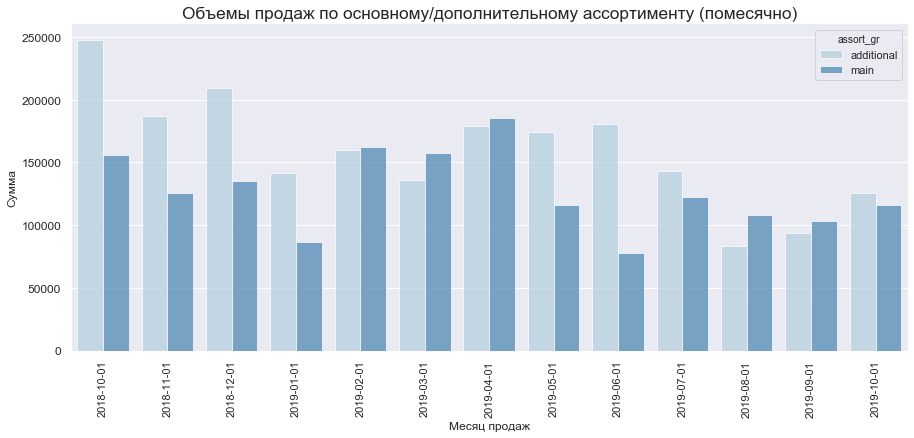

In [41]:
# проверим статистику продаж 
f, ax = plt.subplots(figsize=(15, 6))
sns.barplot(data=df_sales_new.groupby(['month', 'assort_gr'])['summ'].sum().reset_index(), y='summ', x='month',
           palette='Blues', alpha=0.7, hue='assort_gr');
ax.set_title ('Объемы продаж по основному/дополнительному ассортименту (помесячно)', fontdict={'fontsize': 'x-large'})
ax.set_ylabel('Сумма')
ax.set_xlabel('Месяц продаж')
#plt.xlim(0,6000);
#plt.ylim(0,30000);
plt.rc('ytick', labelsize='medium');
plt.xticks(rotation='vertical') 
sns.despine(ax=ax, bottom=True);

Выполняем аналогичную операцию по каждой товарной группе, для визуальной оценки сезонности и тенденций.

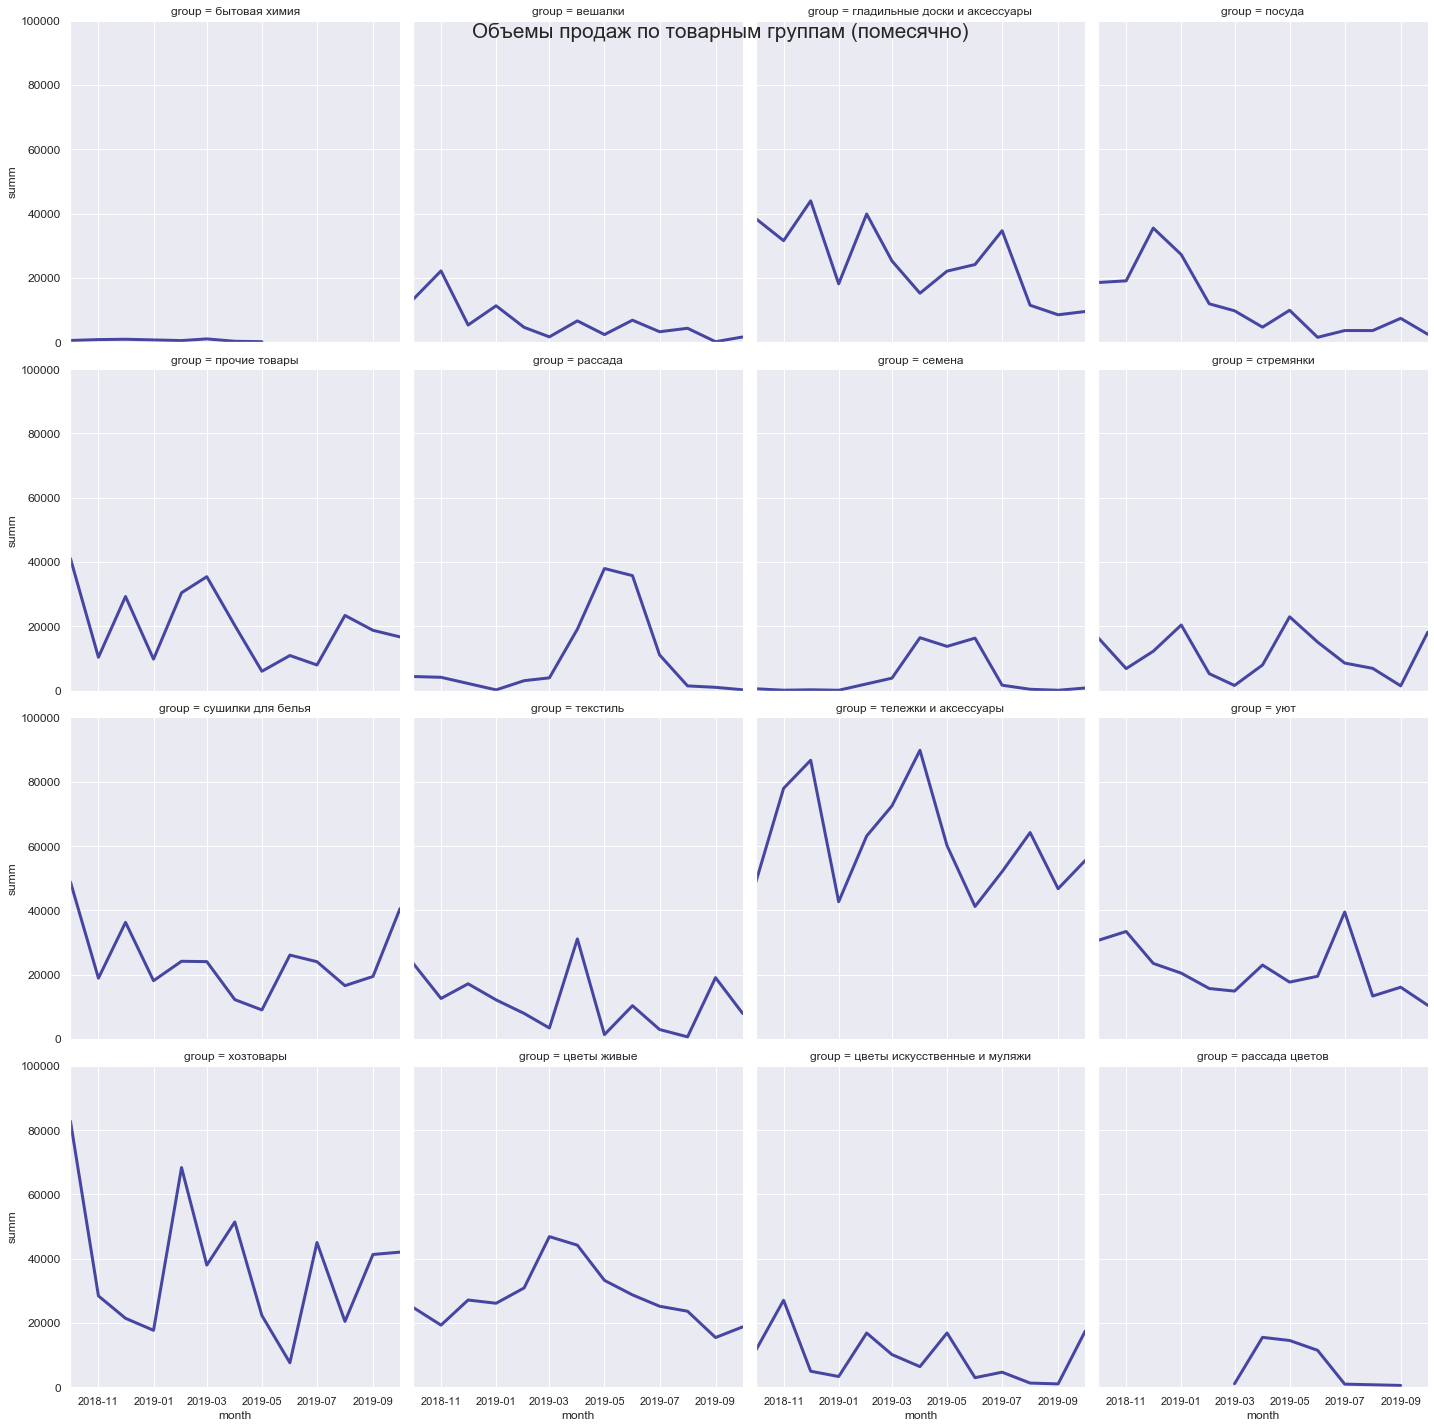

In [42]:
#plt.subplots_adjust(top=3)

#plt.title ('Объемы продаж по товарным группам (помесячно)', fontdict={'fontsize': 'x-large'});
g = sns.relplot(data=df_sales_new.groupby(['month', 'group'])['summ'].sum().reset_index(), 
            kind='line', linewidth=3, 
            y='summ', x='month', color='navy', alpha=0.7, col="group", col_wrap=4); 
plt.xlim('2018-10-01', '2019-10-01');
plt.ylim(0, 100000);
plt.rc('ytick', labelsize='large');
plt.rc('xtick', labelsize='medium');

g.fig.suptitle('Объемы продаж по товарным группам (помесячно)', fontsize='xx-large');

**Выводы:**
- на общем графике продаж видна тенденция спада общих объемов: объем продаж октябрь 2018 значительно больше октября 2019.
- есть сезонный спад общих продаж в январе и августе-сентябре.
- графики основного товарного ассортимента повторяют общие тенденции.
- группы связанные с растениями имеют сезонный всплеск весной, это группы: 'рассада', 'цветы живые', 'рассада цветов', 'семена'.
- 'группы семена' и 'рассада цветов' пользуются спросом только февраля-марта по июль, в остальные периоды продажи почти нулевые.
- интересная особенность у групп 'текстиль' и 'тележки': графики с сильными перепадами, но наиболее выраженный пик продаж приходится на апрель
- в категории 'бытовая химия' продажи с мая отсутствуют.
- отрицательные тенденции продаж заметны в категориях: 'вешалки', 'гладильные доски и аксессуары', 'посуда', 'уют'

<a id='6'></a>
## 6. Проверка гипотез  [▲](#content)

**По результатам проведенного анализа проверяем три гипотезы:**
- Равенство средней цены для основного и доп. ассортимента (это по основному заданию)
- Сезонный рост объема продаж в товарных группах: 'рассада', 'цветы живые', 'рассада цветов', 'семена'.
- Падение общего объема продаж по сравнению октябрь 2018-октябрь 2019

<a id="61"></a>
### 6.1 Проверка гипотезы: "Равенство средней цены товаров основного и доп. ассортимента"  [**↑**](#6)

**Число пользователей по эксперементальным группам:**

In [43]:
# разделяем очищенную выборку на группы с ценами основного/дополнительного ассортимента
samle_main = df_sales_new.loc[df_sales_new['assort_gr']=='main', 'price']
samle_addi = df_sales_new.loc[df_sales_new['assort_gr']=='additional', 'price']

In [44]:
print('Размер выборок:')
print('основной ассортимент:', samle_main.shape[0])
print('дополнительный ассортимент:', samle_addi.shape[0])

Размер выборок:
основной ассортимент: 2227
дополнительный ассортимент: 3538


**Проверка вида распределения конверсии по критерию Шапиро-Уилка.**\
Для выбора критерия сравнения, проверяем данные на соответствие нормальному распределению.

**Проверяем гипотезу:**
- H0 - распределение выборки соответствует нормальному.
- H1 - распределение выборки отличается от нормального.
- alpha = 5%

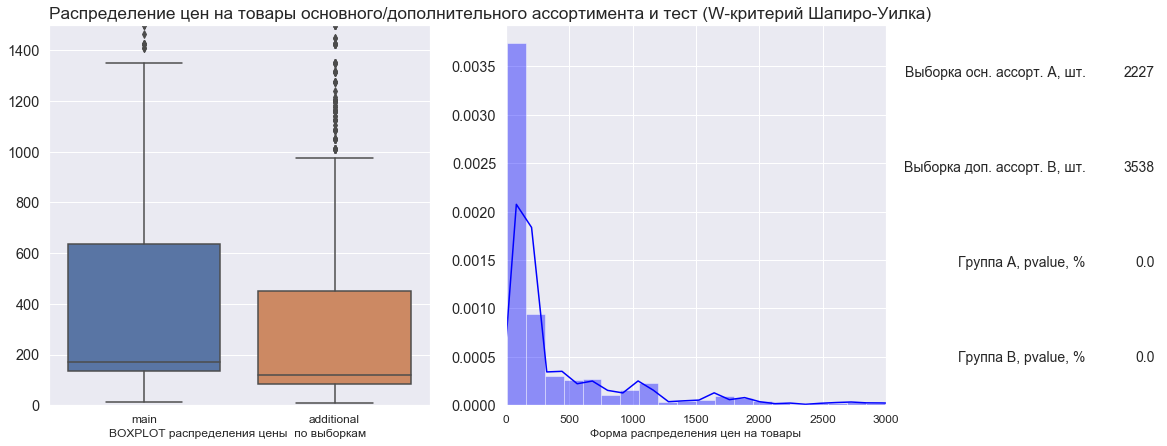

In [45]:
df_sample_1 = df_sales_new[['assort_gr', 'price']]
# формируется таблица с данными теста Шапиро-Уилка
table_shapiro = ([['Выборка осн. ассорт. A, шт.', df_sample_1.loc[df_sample_1['assort_gr']=='main'].shape[0]],
                  ['Выборка доп. ассорт. B, шт.', df_sample_1.loc[df_sample_1['assort_gr']=='additional'].shape[0]],
     ['Группа A, pvalue, %', 
      np.round(st.shapiro(df_sample_1.loc[df_sample_1['assort_gr']=='main', 'price'])[1]*100, 2)],
     ['Группа B, pvalue, %', 
      np.round(st.shapiro(df_sample_1.loc[df_sample_1['assort_gr']=='additional', 'price'])[1]*100, 2)]])
fig, axes = plt.subplots(1, 2, figsize=(15, 7))
# графики распределения
sns.boxplot(data=df_sample_1, y='price', x='assort_gr', ax=axes[0]);
sns.distplot(df_sample_1['price'], bins=100, color='blue', ax=axes[1])
# вывод справочной таблицы
the_table = axes[1].table(cellText=table_shapiro, colWidths=[0.8, 0.2], bbox=(1.02, 0, 0.7, 1), edges='open');
the_table.auto_set_font_size(False)
the_table.set_fontsize(14);
# настройки отображения графиков
axes[0].set_title('Распределение цен на товары основного/дополнительного ассортимента и тест (W-критерий Шапиро-Уилка)',
                   loc='left', fontdict={'fontsize':'x-large'});
axes[0].set_xlabel('BOXPLOT распределения цены  по выборкам ')
axes[0].set_ylabel('')
axes[0].set_ylim(0, 1500);
axes[1].set_xlabel('Форма распределения цен на товары');
axes[1].set_xlim(0, 3000);


Для всех рядов значение pvalue меньше принятого значение alpha=5%. **Отвергаем H0 о соответствии распределения 
нормальному.**

Критерий Манна-Уитни не покажет тонких различий между выборками. Причина в том, что t-критерий работает на основе сравнения средних из фактических наблюдений, в то время как U-критерий Манна-Уитни использует сравнение рангов (номеров наблюдения в упорядоченной выборке), что позволяет ему быть устойчивым к выбросам. При этом критерий Манна-Уитни чувствителен к различию дисперсий и на больших выборках это станет заметно. Если объем выборки больше 20, то распределение выборки для U-критерия быстро сходится к нормальному распределению.\
Можно использовать t-test для оценки средних на большой выборке, так как нормальность обеспечивается ЦПТ (средние отдельных выборок распределения любого вида распеределены нормально). Поэтому t-test не подходит для небольших выборок из ненормального распределения, но подойдет для большой выборки из ненормального распределения.\
Источник: https://your-scorpion.ru/ab-tests-check-mathematics/

**Вывод:** Распределение данных непараметрическое, это видно и визуально и согласно тесту Шапиро-Уилка. Однако, поскольку имеем **более 2000 наблюдений** в каждой выборке, согласно ЦПТ, распределение средних любого распределения будет подчиняться нормальному закону и **можно использовать для проверки t-критерий Стьюдента для независимых выборок.**

 **Проверяем гипотезу о равенстве среднего. Гипотеза:**
 - H0 - средняя цена равна для основного и дополнительного ассортимента.
 - H1 - средняя цена в рядах отличается.
 - alpha = 5%

In [46]:
# функция проверки выборок на равенство среднего по Т-критерию Стьюдента
# по четырем группам событий
# вывод в формата DataFrame; A, B - Series с данными
print('Значение p-value:',
np.round(st.ttest_ind(df_sample_1.loc[df_sample_1['assort_gr']=='main', 'price'],
                      df_sample_1.loc[df_sample_1['assort_gr']=='additional', 'price'])[1], 2))
    

Значение p-value: 0.0


**Вывод:**\
**На принятом уровне значимости 5% средняя цена товаров основного и дополнительного ассортимента отличаются.**

<a id="62"></a>
### 6.2 Проверка гипотезы: "Сезонный рост объема продаж  в товарной группе: 'цветы живые'".  [**↑**](#6)

**Обоснование гипотезы**\
На графиках сезонность выражена в четырех товарных группах:  'рассада', 'цветы живые', 'рассада цветов', 'семена'. Однако в группе живые цветы есть продажи и в остальные периоды, а в остальных трех группах вне сезона продажи почти нулевые. Исходя из этого проводим статистическую проверку только для группы "живые цветы" в период - март-апрель 2019.

In [47]:
# разделяем очищенную выборку на группы
# sample_2 - сумма продаж по дням в группе "живые цветы"
# sample_2A - дневные продажи с 01.03.19 по 30.04.19
# sample_2B - дневные продажи за вычетом периода с 01.03.19 по 30.04.19

sample_2 = df_sales_new.loc[df_sales_new['group']=='цветы живые'].groupby('date')['summ'].sum().reset_index()
sample_2A = sample_2.loc[(sample_2['date'] >='2019-03-01') & (sample_2['date'] <='2019-04-30'), 'summ']
sample_2B = sample_2.loc[(~sample_2.index.isin(sample_2A.index)), 'summ']
sample_2['season'] = 'year'
sample_2.loc[(sample_2.index.isin(sample_2A.index)), 'season'] = 'spring'

**Проверка вида распределения конверсии по критерию Шапиро-Уилка.**\
Для выбора критерия сравнения, проверяем данные на соответствие нормальному распределению.

**Проверяем гипотезу:**
- H0 - распределение выборки соответствует нормальному.
- H1 - распределение выборки отличается от нормального.
- alpha = 5%

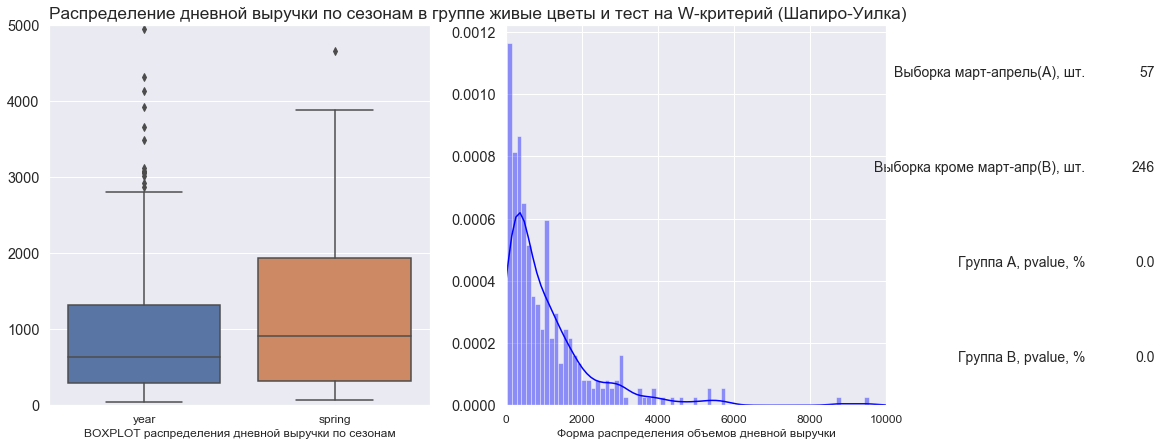

In [48]:
# формируем таблица с данными теста Шапиро-Уилка
table_shapiro = ([['Выборка март-апрель(A), шт.', sample_2A.shape[0]],
                  ['Выборка кроме март-апр(B), шт.', sample_2B.shape[0]],
     ['Группа A, pvalue, %', np.round(st.shapiro(sample_2A)[1]*100, 2)],
     ['Группа B, pvalue, %', np.round(st.shapiro(sample_2B)[1]*100, 2)]])
fig, axes = plt.subplots(1, 2, figsize=(15, 7))
# графики распределения
sns.boxplot(data=sample_2, y='summ', x='season', ax=axes[0]);
sns.distplot(sample_2['summ'], bins=100, color='blue', hist=True, ax=axes[1])
# вывод справочной таблицы
the_table = axes[1].table(cellText=table_shapiro, colWidths=[0.8, 0.2], bbox=(1.02, 0, 0.7, 1), edges='open');
the_table.auto_set_font_size(False)
the_table.set_fontsize(14);
# настройки отображения графиков
axes[0].set_title('Распределение дневной выручки по сезонам в группе живые цветы и тест на W-критерий (Шапиро-Уилка)',
                   loc='left', fontdict={'fontsize':'x-large'});
axes[0].set_xlabel('BOXPLOT распределения дневной выручки по сезонам')
axes[0].set_ylabel('')
axes[0].set_ylim(0, 5000);
axes[1].set_xlabel('Форма распределения объемов дневной выручки');
axes[1].set_xlim(0, 10000);


Для всех рядов значение pvalue меньше принятого значение alpha=5%. **Отвергаем H0 о соответствии распределения 
нормальному.**

**Вывод:** Распределение данных непараметрическое, это видно и визуально и согласно тесту Шапиро-Уилка. Однако, поскольку имеем **значительно больше 20 наблюдений** в каждой выборке, согласно ЦПТ, распределение средних любого распределения будет подчиняться нормальному закону и **можно использовать для проверки t-критерий Стьюдента для независимых выборок.**

 **Проверяем гипотезу о равенстве среднего. Гипотеза:**
 - H0 - продажи живых цветов одинаковы в марте-апреле и в течении остального года
 - H1 - продажи живых цветов больше в марте-апреле, чем в остальные периоды
 - alpha = 5%
 **Поскольку альтернативная гипотеза односторонняя, полученный pvalue делим на 2.**

In [49]:
# функция проверки выборок на равенство среднего по Т-критерию Стьюдента
# по четырем группам событий
# вывод в формата DataFrame; A, B - Series с данными
print('Значение p-value:',
    np.round(st.ttest_ind(sample_2A, sample_2B)[1] / 2, 3))   

Значение p-value: 0.021


**Вывод:**\
**На принятом уровне значимости 5% объем продаж в марте-апреле отличаются от продаж в остальные периоды, в соответствии с альтернативной гипотезой -  больше.**

<a id="63"></a>
### 6.3 Проверка гипотезы: "Падение продаж в течение года".  [**↑**](#6)

**Обоснование гипотезы**\
В данном случае, из-за нехватки данных, мы не имеем возможности сравнить продажи год к году. Тем не менее в наличии статистика продаж за 13 месяцев, что позволяет сравнить продажи в октябре 2018 и октябре 2019г. Сравнивать остальные месяцы между собой некорректно, поскольку могут существовать сезонные факторы влияющие на объем продаж.

In [50]:
# разделяем очищенную выборку на группы
# sample_3 - дневные продажи в октябре 2018 и в октябре 2019
# sample_3A - дневные продажи с 01.03.18 по 31.10.18
# sample_3B - дневные продажи с 01.03.19 по 31.10.19

sample_3 = (df_sales_new.loc[((df_sales_new['date'] >'2018-10-01') & (df_sales_new['date'] <'2018-10-31'))
                            | ((df_sales_new['date'] >'2019-10-01') & (df_sales_new['date'] <'2019-10-31'))]
                            .groupby('date')['summ'].sum().reset_index())
sample_3A = sample_3.loc[(sample_3['date'] >'2018-10-01') & (sample_3['date'] <'2018-10-31'), 'summ']
sample_3B = sample_3.loc[(~sample_3.index.isin(sample_3A.index)), 'summ']
sample_3['year'] = '2019'
sample_3.loc[(sample_3.index.isin(sample_3A.index)), 'year'] = '2018'

**Проверка вида распределения конверсии по критерию Шапиро-Уилка.**\
Для выбора критерия сравнения, проверяем данные на соответствие нормальному распределению.

**Проверяем гипотезу:**
- H0 - распределение выборки соответствует нормальному.
- H1 - распределение выборки отличается от нормального.
- alpha = 5%

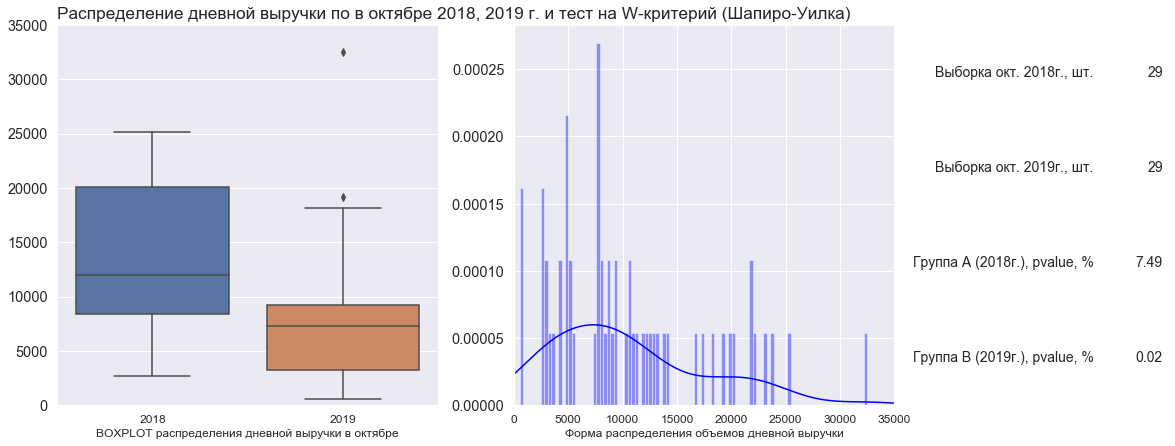

In [51]:
# формируем таблица с данными теста Шапиро-Уилка
table_shapiro = ([['Выборка окт. 2018г., шт.', sample_3A.shape[0]],
                  ['Выборка окт. 2019г., шт.', sample_3B.shape[0]],
     ['Группа A (2018г.), pvalue, %', np.round(st.shapiro(sample_3A)[1]*100, 2)],
     ['Группа B (2019г.), pvalue, %', np.round(st.shapiro(sample_3B)[1]*100, 2)]])
fig, axes = plt.subplots(1, 2, figsize=(15, 7))
# графики распределения
sns.boxplot(data=sample_3, y='summ', x='year', ax=axes[0]);
sns.distplot(sample_3['summ'], bins=100, color='blue', ax=axes[1], hist=True)
# вывод справочной таблицы
the_table = axes[1].table(cellText=table_shapiro, colWidths=[0.8, 0.2], bbox=(1.02, 0, 0.7, 1), edges='open');
the_table.auto_set_font_size(False)
the_table.set_fontsize(14);
# настройки отображения графиков
axes[0].set_title('Распределение дневной выручки по в октябре 2018, 2019 г. и тест на W-критерий (Шапиро-Уилка)',
                   loc='left', fontdict={'fontsize':'x-large'});
axes[0].set_xlabel('BOXPLOT распределения дневной выручки в октябре')
axes[0].set_ylabel('')
axes[0].set_ylim(0, 35000);
axes[1].set_xlabel('Форма распределения объемов дневной выручки');
axes[1].set_xlim(0, 35000);


Для всех рядов значение pvalue меньше принятого значение alpha=5%. **Отвергаем H0 о соответствии распределения 
нормальному.**

**Вывод:** Вид распределения данных смешанный. На принятом уровне значимости для выборки 2018г. оно может считаться нормальным, для 2019 - нет. Учитывая малый размер выборки будем использовать для проверки U-тест Манна-Уитни. 

 **Проверяем гипотезу о равенстве среднего. Гипотеза:**
 - H0 - продажи в октябре 2019 равны продажам в октябре 2018
 - H1 - продажи в октябре 2019 меньше продаж в октябре 2019
 - alpha = 5%\
 **Поскольку альтернативная гипотеза односторонняя, полученный pvalue делим на 2.**

In [52]:
# функция проверки выборок на равенство среднего по U-тест Манна-Уитни
# pvalue - делится на 2 поскольку альтернативная гипотеза односторонняя
print('Значение p-value:',
    np.round(st.mannwhitneyu(sample_3A, sample_3B)[1]/2, 3))    

Значение p-value: 0.0


**Вывод:**\
**На принятом уровне значимости 5% объем продаж в октябре 2019 отличатся от объема продаж октября 2018г, т.е. меньше.**

<a id='summary'></a>
## Общий вывод  [▲](#content)

1. Выполнена разбивка ассортимента на 16 товарных групп.
2. К основному ассортименту магазина относятся товарные группы: **'цветы живые', 'тележки и аксессуары', 'хозтовары'**
3. Группы связанные с растениями имеют сезонный всплеск весной, это группы: 'рассада', 'цветы живые', 'рассада цветов', 'семена'. Группы 'семена' и 'рассада цветов' пользуются спросом только февраля-марта по июль, в остальные периоды продажи почти нулевые. 

4. Средняя цена товаров основного и дополнительного ассортимента не имеют статистически значимых отличий.
5. Рост продаж живых цветов в марте-апреля подтверждается статистически.
6. Есть статистически подтверждаемый спад объемов продаж октября 2019 к октябрю 2018г.
7. В категории 'бытовая химия' продажи с мая отсутствуют. Отрицательные тенденции объемов продаж заметны в категориях: 'вешалки', 'гладильные доски и аксессуары', 'посуда', 'уют'.

**Список использованных источников:**

**Официальная документация к библиотекам**\
(для постоянного использования по синтаксису, примерам визуализации и т.п.):\
	Pandas - https://pandas.pydata.org/pandas-docs/stable/ \
	seaborn - https://seaborn.pydata.org/index.html \
	scipy.stats - https://docs.scipy.org/doc/scipy/reference/stats.html \
	scikit-learn - https://scikit-learn.org/stable/index.html \
	Plotly - https://plot.ly/python/
	
**Прчие вопросы:**

- Документация по библиотеке лемматизации pymystem3
https://github.com/nlpub/pymystem3
https://pythonhosted.org/pymystem3/pymystem3.html#submodules
https://nlpub.mipt.ru/Mystem#Python

- Как фильтровать строки в Pandas с помощью регулярных выражений
https://www.rupython.com/pandas-x449-28153.html

- Регулярные выражения в Python (одна из лучших и полных статей по теме)
https://habr.com/ru/post/349860/#Primery_regulyarnyh_vyrazheniy

- Фикс для бага seaborn.heatmap (при работе в версиях Matplotlib до 3.1.2),
(обрезка отображения верхних и нижних ячеек в heatmap)
https://github.com/mwaskom/seaborn/issues/1773

- автоматизированная подготовка файла requirements.txt
http://zabaykin.ru/?p=436
https://stackoverflow.com/questions/31684375/automatically-create-requirements-txt
https://medium.com/@boscacci/why-and-how-to-make-a-requirements-txt-f329c685181e

**Статистические функции и тесты:**

- Выбор статистического критерия для тестирования гипотез
https://lit-review.ru/biostatistika/vybor-statisticheskogo-kriteriya/

- Проверка результатов A/B теста
https://your-scorpion.ru/ab-tests-check-mathematics/

- Python в анализе данных (проверка бинарных распределений)
https://your-scorpion.ru/python-data-analysis/

- Непараметрические тесты статистической значимости в Python
https://www.machinelearningmastery.ru/nonparametric-statistical-significance-tests-in-python/

**SQL**
- инсталляция и основные приемы работы 
в psycopg2 - Python / Jupyter библиотеки-интерфейса к PostgreSQL
https://khashtamov.com/ru/postgresql-python-psycopg2/
- учебник по базовым операторам SQL
http://www.sql-tutorial.ru/ru/book_subqueries.html (построение подзапросов)
- группировка с агрегатными функциями
https://function-x.ru/sql_group_by.html#paragraph3
- получение информации о типе полей в таблицах
http://blog.pws.ru/2013/08/07/postgressql-table-structure/
- преобразование типа данных
http://www.sql-tutorial.ru/ru/book_type_conversion_and_cast_function/page1.html
https://www.postgresqltutorial.com/postgresql-cast/

**ML**
- Решение для классификации названий продуктов из чеков в приложении
https://habr.com/ru/post/430216/


